In [2]:
import pandas as pd
import collections 
import proteomics.sequence as sequence
import copy
import re
import os
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
#infile = "/home/FILESERVER5/proteomics/tss38/WT/PD/raw/RNA_Peptide_Trizol.xlsx"
infile = "/home/FILESERVER5/proteomics/tss38/git_repos/CamProt/raw/RNA_Ptn_Trizol.xlsx"
fasta_inf = "/home/FILESERVER5/proteomics/tss38/git_repos/CamProt/raw/Human_201701.fasta"
crap_inf = "/home/FILESERVER5/proteomics/tss38/git_repos/CamProt/raw/cRAP_FullIdentifiers.fasta"

In [4]:
# code 'borrowed' from CGAT.FastaIterator (trying to limit dependencies)

class FastaRecord:
    """a :term:`fasta` record.

    Attributes
    ----------
    title: string
       the title of the sequence

    sequence: string
       the sequence

    fold : int
       the number of bases per line when writing out
    """

    def __init__(self, title, sequence, fold=False):

        self.title = title
        self.sequence = sequence
        self.fold = fold

    def __str__(self):
        ''' str method for writing out'''

        if self.fold:
            seq = [self.sequence[i:i + self.fold]
                   for i in range(0, len(self.sequence), self.fold)]
        else:
            seq = (self.sequence,)

        return ">%s\n%s" % (self.title, "\n".join(seq))

    
class FastaIterator:
    '''a iterator of :term:`fasta` formatted files.

    Yields
    ------
    FastaRecord

    '''

    def __init__(self, f, *args, **kwargs):
        self.iterator = iterate(f)

    def __iter__(self):
        return self

    def __next__(self):
        return next(self.iterator)

    def next(self):
        return next(self.iterator)


def iterate(infile, comment="#", fold=False):
    '''iterate over fasta data in infile

    Lines before the first fasta record are
    ignored (starting with ``>``) as well as
    lines starting with the comment character.

    Parameters
    ----------
    infile : File
        the input file
    comment : char
        comment character
    fold : int
        the number of bases before line split when writing out

    Yields
    ------
    FastaRecord
    '''

    h = infile.readline()[:-1]

    if not h:
        raise StopIteration

    # skip everything until first fasta entry starts
    while h[0] != ">":
        h = infile.readline()[:-1]
        if not h:
            raise StopIteration
        continue

    h = h[1:]
    seq = []

    for line in infile:

        if line.startswith(comment):
            continue

        if line.startswith('>'):
            yield FastaRecord(h, ''.join(seq), fold)

            h = line[1:-1]
            seq = []
            continue

        seq.append(line[:-1])

    yield FastaRecord(h, ''.join(seq), fold)


In [5]:
df = pd.read_excel(infile)
df['Show Spectrum'] = df['Show Spectrum'].astype(str)
df['All localization scores'] = df['All localization scores'].astype(str)
df['Best localization(s)'] = df['Best localization(s)'].astype(str)


In [6]:
df['tr_only'] = [x.count("sp|")>0 for x in df['Proteins']]
df['matches'] = [len(x.split(",")) for x in df['Proteins']]


In [31]:
df2 = df[['tr_only', 'Score', 'Best loc score', 'matches', 'Best localization(s)']]

  tr_only     Score Best.loc.score matches Best.localization.s. crosslinked
0    TRUE 0.6392479        0.00000       6                  nan       FALSE
1    TRUE 0.4237237      151.16437       3        HACCEHfQMQLRS        TRUE
2    TRUE 0.1508856       65.72360       1       CYMYqARDLAAMDK        TRUE
3    TRUE 2.7933153       26.61265       1          LQhWIHSCLRK        TRUE
4    TRUE 0.1214534      120.94383       2  DPVLYMYTLLDDyKDGDLR        TRUE
5    TRUE 4.8545825        0.00000       2                  nan       FALSE


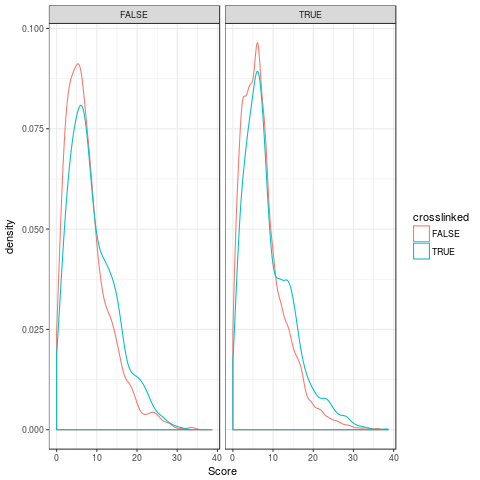

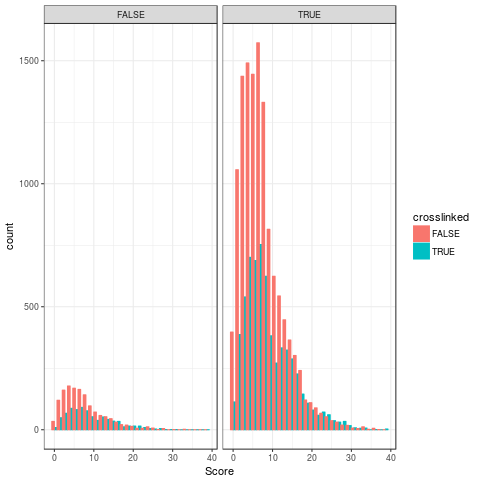

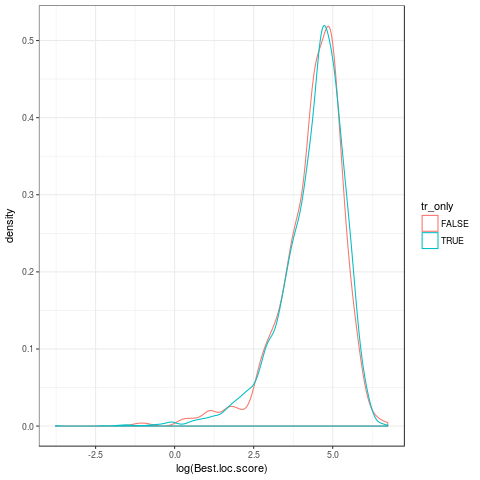

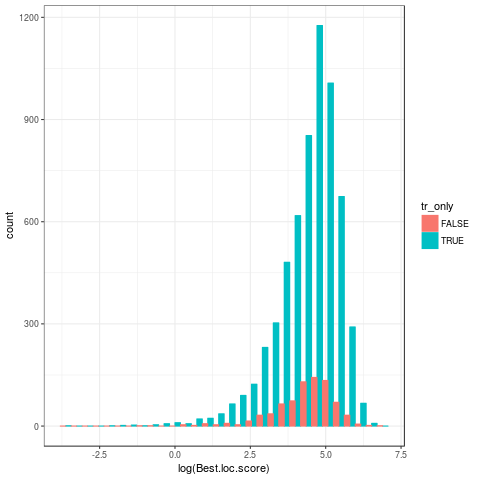

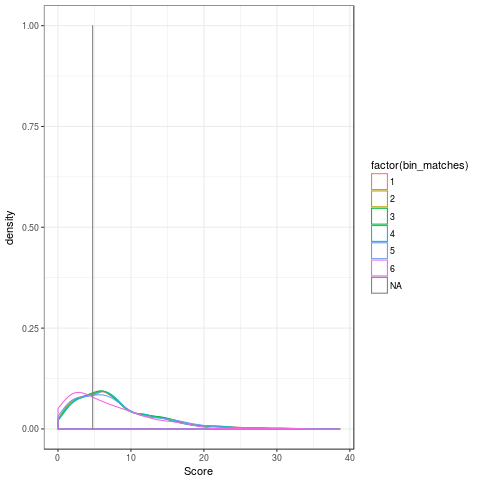

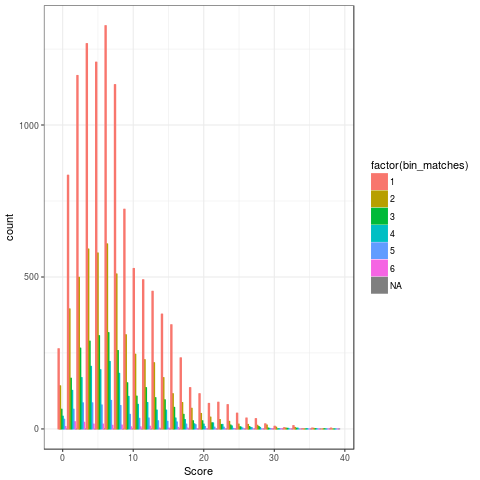

In [37]:
%%R -i df2

library(ggplot2)
df2['crosslinked'] <- df2[['Best.localization.s.']]!='nan'
print(head(df2))
df2$Score <- as.numeric(as.character(df2$Score))
df2$Best.loc.score <- as.numeric(as.character(df2$Best.loc.score))

p = ggplot(df2, aes(Score)) + theme_bw() + facet_wrap(~tr_only)

p1 = p + geom_density(aes(colour=crosslinked))
p2 = p + geom_histogram(position='dodge', aes(colour=crosslinked, fill=crosslinked))

print(p1)
print(p2)

p = ggplot(df2, aes(log(Best.loc.score))) + theme_bw()

p1 = p + geom_density(aes(colour=tr_only))
p2 = p + geom_histogram(position='dodge', aes(colour=tr_only, fill=tr_only))

print(p1)
print(p2)


df2$bin_matches <- .bincode(df2$matches, breaks=c(0,1,2,3,5,10,100))
#print(head(df))
p = ggplot(df2, aes(Score)) + theme_bw()
p3 = p + geom_density(aes(colour=factor(bin_matches)))
p4 = p + geom_histogram(position='dodge', aes(colour=factor(bin_matches), fill=factor(bin_matches)))

print(p3)
print(p4)

In [8]:
proteins = list()
for group in df['Proteins']:
    proteins.extend([x.split("|")[1] for x in group.split(",")])
    

print(len(df['Proteins']))
print(len(proteins))

#seq_dict = {accession:seq for accession, taxid, seq, method in sequence.getSequences(set(proteins))}


21163
44187


In [10]:
pep2pro = collections.defaultdict(lambda: collections.defaultdict(set))
pep2allpro = collections.defaultdict(set)
pro2pep = collections.defaultdict(set)
top_level_proteins = set()
initial_proteins = set()
#print(df.head(2))

for row_ix, row_values in df[['Proteins', 'Peptide']].iterrows():

    proteins = row_values['Proteins'].split(",")
    peptide = row_values['Peptide']

    if peptide in pep2pro:
        assert pep2allpro[peptide] == proteins, (
            "The same peptide is observed more than once with different proteins!")
    pep2allpro[peptide] = proteins
    for protein in proteins:
        initial_proteins.add(protein)
        pro2pep[protein].add(peptide)
        
        if protein.split("|")[0] == "sp":
            protein_level = 1
            top_level_proteins.add(protein)
        elif protein.split("|")[0] == "tr":
            protein_level = 2
            #top_level_proteins.add(protein)
        else:
            raise ValueError("Protein does not appear to be either SwissProt(sp) or TrEMBL(tr)")

        pep2pro[peptide][protein_level].add(protein)
    
print(len(initial_proteins))
print(len(pep2pro))
print(df.shape)


25527
20878
(21163, 32)


In [11]:
print(len(top_level_proteins))

10426


In [13]:
tr_only_peptides = set([x for x in pep2pro.keys() if len(pep2pro[x][1])==0])

for peptide in tr_only_peptides:
    upgraded = pep2pro[peptide][2]
    top_level_proteins.update(upgraded)
    pep2pro[peptide][2] = pep2pro[peptide][2].difference(set(upgraded))
    pep2pro[peptide][1] = pep2pro[peptide][1].union(set(upgraded))
print(upgraded)

{'tr|A0A0A0MR30|A0A0A0MR30_HUMAN'}


In [14]:
retained_proteins = []
peptides = copy.deepcopy(set(pep2pro.keys()))
peptide_counts = {}

tmppro2pep = copy.deepcopy(pro2pep)
new_top_level_proteins = copy.deepcopy(top_level_proteins)
new_pep2pro = collections.defaultdict(set)

n = max(map(len, tmppro2pep.values()))
print(len(peptides))
while True:

    if n == 0:
        break

    #n = min(n-1, top_score+1)
    n -= 1 

    if len(peptides) == 0:
        break
    top_proteins = set()
    top_score = 0
    for protein in new_top_level_proteins:
        if len(tmppro2pep[protein]) == top_score:
            top_proteins.add(protein)
        elif len(tmppro2pep[protein]) > top_score:
            top_score = len(tmppro2pep[protein])
            top_proteins = set((protein,))

    for top_protein in top_proteins:
        #print(top_protein, top_score, len(new_pep2pro), len(new_top_level_proteins))
    
        try:
            new_top_level_proteins.remove(top_protein)
        except:
            print(top_score)
            print(len(peptides))
            print(top_protein, tmppro2pep[top_protein])
            raise ValueError()
    
        retained_proteins.append(top_protein)
    
        for peptide in pro2pep[top_protein]:
            new_pep2pro[peptide].add(top_protein)
            if peptide in peptides:
                peptides.remove(peptide)
            for protein in pep2pro[peptide][1]:
                if protein == top_protein:
                    continue
                if peptide in tmppro2pep[protein]:
                    tmppro2pep[protein].remove(peptide)
    print(len(peptides), top_score)
print(peptides)
print("\n\npeptides dicts:\n")
assert set(pep2pro.keys()).difference(set(new_pep2pro.keys())) == set()

20878
20814 64
20814 44
20774 40
20748 26
20725 23
20705 20
20687 18
20639 16
20578 15
20536 14
20458 13
20293 11
20143 10
19944 9
19599 8
19161 7
18312 6
16963 5
14881 4
11588 3
6286 2
0 1
set()


peptides dicts:



In [65]:
df['top_protein(s)'] = [";".join(new_pep2pro[protein]) for protein in df['Peptide']]
df['top_uniprot_id(s)'] = [";".join([protein_id.split("|")[1] for protein_id in new_pep2pro[protein]])
                           for protein in df['Peptide']]
print(df.head())
print(len(set(df['top_protein(s)'])))
print(len(set(df['top_uniprot_id(s)'])))

  Checked                                      Show Spectrum         RT  \
0   False  -52;1671;(304.154,25.6,"[b3]+")|(249.178,8.0,"...  12.372800   
1   False  -52;2594;(1458.469,53.0,"[b11]+")|(325.128,24....  19.493300   
2   False  -52;2627;(817.805,0.6,"[b6]+")|(487.129,6.7,"[...  19.740383   
3   False  -52;2639;(189.203,0.5,"[b4]+++")|(226.163,0.2,...  19.820333   
4   False  -52;2776;(801.647,0.2,"[b13]++")|(865.512,0.3,...  20.871150   

   Original m/z                                           Proteins  \
0      322.6771  sp|Q9H2X9|S12A5_HUMAN,sp|Q9UP95|S12A4_HUMAN,sp...   
1     1062.3724  sp|P04798|CP1A1_HUMAN,tr|E7EMT5|E7EMT5_HUMAN,t...   
2     1069.3793                               sp|O75923|DYSF_HUMAN   
3      595.2694                              sp|P51178|PLCD1_HUMAN   
4      903.7130       sp|Q56A73|SPIN4_HUMAN,tr|X6R8Y7|X6R8Y7_HUMAN   

             RNA                                            Peptide  Charge  \
0           none                                 

In [85]:
initial_proteins = set()
final_proteins = set()
initial_sp_proteins = set()
final_sp_proteins = set()

for protein in df['Proteins']:
    for p in protein.split(","):
        initial_proteins.add(p.split("|")[1])
        if p.split("|")[0] == "sp":
            initial_sp_proteins.add(p.split("|")[1])
            

for protein in df['top_protein(s)']:
    for p in protein.split(";"):
        final_proteins.add(p.split("|")[1])
        if p.split("|")[0] == "sp":
            final_sp_proteins.add(p.split("|")[1])

print(len(initial_proteins), len(final_proteins))
print(len(initial_sp_proteins), len(final_sp_proteins))

25527 11885
10426 9596


In [86]:
counts = collections.Counter([len(x.split(";")) for x in df['top_protein(s)']])
print([y/sum(counts.values()) for x,y in counts.most_common()])


[0.9391390634598119, 0.04668525256343618, 0.008694419505741152, 0.003024145915040401, 0.0009450455984501252, 0.0005670273590700751, 0.0002362613996125313, 0.00018900911969002505, 0.00014175683976751878, 9.450455984501253e-05, 4.7252279922506264e-05, 4.7252279922506264e-05, 4.7252279922506264e-05, 4.7252279922506264e-05, 4.7252279922506264e-05, 4.7252279922506264e-05]


In [211]:
cRAP_proteins = set()
protein2description = {entry.title.split(" ")[0]: " ".join(entry.title.split(" ")[1:])
                       for entry in FastaIterator(open(fasta_inf))}
protein2seq = {entry.title.split(" ")[0]:entry.sequence for entry in FastaIterator(open(fasta_inf))}
print(len(protein2seq))
for entry in FastaIterator(open(crap_inf)):
    protein2seq[entry.title.split(" ")[0]] = entry.sequence
    protein2description[entry.title.split(" ")[0]] = entry.title.split(" ")[0]
    cRAP_proteins.add(entry.title.split(" ")[0])
print(len(protein2seq))

70956
71071


In [241]:
print(row['Proteins'].split(","), matches)

['sp|Q70Z53|F10C1_HUMAN'] {'sp|Q70Z53|F10C1_HUMAN'}


In [240]:
# check whether RNPxl identifies all protein matches OK?
n1 = 0
n2 = 0
for row_ix, row in df.iterrows():
    n1 += 1
    peptide = row['Best localization(s)']
    if n1 % 500 == 0:
        print("done %i lines and checked %i peptide matches" %(n1, n2))
    if peptide != "nan":
        n2 += 1
        matches = set()
        peptide = peptide.upper()
        for protein, seq in protein2seq.items():
            if peptide in seq.upper():
                matches.add(protein)
        if not set(row['Proteins'].split(",")) == matches:
            print(row['Proteins'], matches)
            break
print(row['Best localization(s)'])

done 500 lines and checked 152 peptide matches
done 1000 lines and checked 296 peptide matches
done 1500 lines and checked 460 peptide matches
done 2000 lines and checked 616 peptide matches
done 2500 lines and checked 769 peptide matches
done 3000 lines and checked 910 peptide matches
done 3500 lines and checked 1037 peptide matches
done 4000 lines and checked 1174 peptide matches
done 4500 lines and checked 1329 peptide matches
done 5000 lines and checked 1461 peptide matches
done 5500 lines and checked 1614 peptide matches
done 6000 lines and checked 1782 peptide matches
done 6500 lines and checked 1920 peptide matches
done 7000 lines and checked 2077 peptide matches
done 7500 lines and checked 2243 peptide matches
done 8000 lines and checked 2416 peptide matches
done 8500 lines and checked 2610 peptide matches
done 9000 lines and checked 2800 peptide matches
done 9500 lines and checked 2974 peptide matches
done 10000 lines and checked 3133 peptide matches
done 10500 lines and check

In [142]:
for entry in FastaIterator(open(fasta_inf)):
    if "P04798" in entry.title:
        print(entry)

>sp|P04798|CP1A1_HUMAN Cytochrome P450 1A1 OS=Homo sapiens GN=CYP1A1 PE=1 SV=1
MLFPISMSATEFLLASVIFCLVFWVIRASRPQVPKGLKNPPGPWGWPLIGHMLTLGKNPHLALSRMSQQYGDVLQIRIGSTPVVVLSGLDTIRQALVRQGDDFKGRPDLYTFTLISNGQSMSFSPDSGPVWAARRRLAQNGLKSFSIASDPASSTSCYLEEHVSKEAEVLISTLQELMAGPGHFNPYRYVVVSVTNVICAICFGRRYDHNHQELLSLVNLNNNFGEVVGSGNPADFIPILRYLPNPSLNAFKDLNEKFYSFMQKMVKEHYKTFEKGHIRDITDSLIEHCQEKQLDENANVQLSDEKIINIVLDLFGAGFDTVTTAISWSLMYLVMNPRVQRKIQEELDTVIGRSRRPRLSDRSHLPYMEAFILETFRHSSFVPFTIPHSTTRDTSLKGFYIPKGRCVFVNQWQINHDQKLWVNPSEFLPERFLTPDGAIDKVLSEKVIIFGMGKRKCIGETIARWEVFLFLAILLQRVEFSVPLGVKVDMTPIYGLTMKHACCEHFQMQLRS


In [226]:
protein_lengths = []
protein_descriptions = []
crap_proteins = []

position_in_peptide = []
position_in_protein = []

motif_13 = []
motif_15 = []
motif_17 = []

def getMotifWindow(positions, proteins, length):
    assert len(positions) == len(proteins), "must have as many positions as proteins"
    windows = set()

    for position, protein_seq in zip(positions, proteins):
        buffer = ((length - 1) / 2)
        windows.add(protein_seq[int(position-buffer): int(position+buffer) + 1])

    if min([len(x) for x in windows]) != length:
        return "protein_too_short_for_window"
    if len(windows) == 1:
        return list(windows)[0]
    else:
        return "different_sequences_for_the_proteins"

for ix, row in df.iterrows():
    peptide = row['Best localization(s)']
    proteins = row['top_protein(s)'].split(";")
    protein_lengths.append(";".join(map(str, [len(protein2seq[x]) for x in proteins])))
    protein_descriptions.append(";".join([protein2description[x] for x in proteins]))
    
    crap_protein = 0
    for protein in proteins:
        if protein in cRAP_proteins:
            crap_protein = 1
            break
    crap_proteins.append(crap_protein)
        
    
    if row['Best localization(s)']!='nan' and row['Best loc score']>0:
        
        peptide_positions = [re.search(peptide.upper(), protein2seq[x]).start() for
                             x in proteins]
        crosslink_position = None
        for ix, aa in enumerate(peptide):
            if aa == aa.lower():
                crosslink_position = ix
        assert crosslink_position is not None, "no crosslinked position was found(!): %s" % peptide
        
        position_in_peptide.append(crosslink_position + 1)
        
        protein_positions = [crosslink_position + x for x in peptide_positions]
        position_in_protein.append(";".join(map(str, [x + 1 for x in protein_positions])))
        
        motif_13.append(
            getMotifWindow(protein_positions, [protein2seq[x] for x in proteins], 13))
        motif_15.append(
            getMotifWindow(protein_positions, [protein2seq[x] for x in proteins], 15))
        motif_17.append(
            getMotifWindow(protein_positions, [protein2seq[x] for x in proteins], 17))

    else:
        position_in_peptide.append("no_crosslink")
        position_in_protein.append("no_crosslink")
        motif_13.append("no_crosslink")
        motif_15.append("no_crosslink")
        motif_17.append("no_crosslink")


df['protein_length(s)'] = protein_lengths
df['protein_description(s)'] = protein_descriptions
df['crap_protein'] = crap_proteins

df['position_in_peptide'] = position_in_peptide
df['position_in_protein(s)'] = position_in_protein

df['window_13'] = motif_13
df['window_15'] = motif_15
df['window_17'] = motif_17

In [221]:
print(df.shape)

print(df['crap_protein'].value_counts())
print(df['window_13'].value_counts().head(3))
print(df['window_15'].value_counts().head(3))
print(df['window_17'].value_counts().head(3))
print(df[df['window_17']=='different_sequences_for_the_proteins'].head())
print(df[df['crap_protein']==1].head())

(21163, 42)
0    21083
1       80
Name: crap_protein, dtype: int64
no_crosslink                            14289
protein_too_short_for_window              210
different_sequences_for_the_proteins       62
Name: window_13, dtype: int64
no_crosslink                            14289
protein_too_short_for_window              267
different_sequences_for_the_proteins       70
Name: window_15, dtype: int64
no_crosslink                            14289
protein_too_short_for_window              327
different_sequences_for_the_proteins       73
Name: window_17, dtype: int64
     Checked                                      Show Spectrum         RT  \
256    False  -52;3994;(268.209,10.3,"[b3]+")|(415.435,2.7,"...  28.260817   
922    False  -52;5581;(359.017,3.5,"[b3]+")|(209.181,1.1,"[...  34.105717   
1036   False  -52;5855;(301.245,1.1,"[b5]++")|(602.527,2.2,"...  34.848317   
1060   False  -52;5907;(228.085,14.5,"[b2]+")|(327.273,5.5,"...  34.972683   
1148   False  -52;6120;(104.147,1.2,"[b

In [230]:
new_column_order = ["Best localization(s)", "RNA", "top_protein(s)", "top_uniprot_id(s)",
                    'protein_description(s)', 'protein_length(s)',
                    'position_in_peptide', 'position_in_protein(s)', 
                    'window_13', 'window_15', 'window_17', 'crap_protein',
                    "Peptide", "Proteins"]
  
new_column_order.extend([x for x in df.columns if x not in new_column_order])
final_df = df[new_column_order]

final_df.to_csv(os.path.join(os.path.dirname(infile), "RNA_Ptn_Trizol_test_output.tsv"),
                index=False, sep="\t")